# Import Library

In [229]:
import numpy as np
import pandas as pd
import re
import spacy
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM  
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 确保 spacy 模型已下载
# python -m spacy download en_core_web_sm


In [230]:

print(tf.__version__)
print(keras.__version__)


2.17.0
3.4.1


# Read Data

In [231]:
df = pd.read_csv('/Users/coco/Downloads/learning_chatbot/data/dataset.csv')

In [232]:
df.head()

,Sentence,Type
0,"Ali, who was two at the time, loved the story ...",Auditory
1,"Look at my dad, spiffed up in jodhpurs, ready ...",Auditory
2,Believe me it's far more difficult to know wha...,Auditory
3,"The Surrealists loved bad movies, seeing them ...",Auditory
4,"He idolised prize-fighters, regarded racketeer...",Auditory


In [233]:
print(f'There are {df.shape[0]} rows and {df.shape[1]} columns')

There are 15450 rows and 2 columns


In [234]:
df.describe()

,Sentence,Type
count,15450,15450
unique,14594,3
top,Show More Sentences,Visual
freq,667,5827


In [235]:
temp = df.groupby('Type').count()['Sentence'].reset_index().sort_values(by='Sentence',ascending=False)
temp.style.background_gradient(cmap='Purples')

,Type,Sentence
2,Visual,5827
1,Kinesthetic,4819
0,Auditory,4804


# Data Cleaning

In [236]:
df.isnull().sum()

Sentence    0
Type        0
dtype: int64

In [237]:
df['Sentence'].duplicated().sum()

856

In [238]:
duplicateRows = df[df.duplicated()]

In [239]:
duplicateRows

,Sentence,Type
297,Show More Sentences,Visual
318,Show More Sentences,Visual
339,Show More Sentences,Visual
360,Show More Sentences,Visual
381,Show More Sentences,Visual
...,...,...
15345,Show More Sentences,Kinesthetic
15366,Show More Sentences,Kinesthetic
15387,Show More Sentences,Kinesthetic
15408,Show More Sentences,Kinesthetic


In [240]:
df.drop_duplicates(inplace=True,keep=False)
df.shape

(14595, 2)

In [241]:
temp = df.groupby('Type').count()['Sentence'].reset_index().sort_values(by='Sentence',ascending=False)
temp.style.background_gradient(cmap='Purples')

,Type,Sentence
2,Visual,5527
1,Kinesthetic,4572
0,Auditory,4496


In [242]:
df.head()

,Sentence,Type
0,"Ali, who was two at the time, loved the story ...",Auditory
1,"Look at my dad, spiffed up in jodhpurs, ready ...",Auditory
2,Believe me it's far more difficult to know wha...,Auditory
3,"The Surrealists loved bad movies, seeing them ...",Auditory
4,"He idolised prize-fighters, regarded racketeer...",Auditory


In [243]:
nlp = spacy.load('en_core_web_sm')

In [244]:
df['Sentence_modified'] = df['Sentence'].apply(lambda x: [doc.lemma_ for doc in  nlp(x) if not doc.is_stop])
df['Sentence_modified'] = df['Sentence_modified'].apply(lambda x: " ".join(x))

In [245]:
df.head()

,Sentence,Type,Sentence_modified
0,"Ali, who was two at the time, loved the story ...",Auditory,"Ali , time , love story little girl live teeny..."
1,"Look at my dad, spiffed up in jodhpurs, ready ...",Auditory,"look dad , spiffe jodhpur , ready ride bay mar..."
2,Believe me it's far more difficult to know wha...,Auditory,believe far difficult know unconscious love mo...
3,"The Surrealists loved bad movies, seeing them ...",Auditory,"Surrealists love bad movie , see subversive at..."
4,"He idolised prize-fighters, regarded racketeer...",Auditory,"idolise prize - fighter , regard racketeer fri..."


In [246]:
def clean_text(text):
    text = re.sub(r"https?://\w+\.\w+\.\w+", "", text).lower()
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    text = text.replace(".", " " )
    text = text.replace(",", " " )
    text = text.replace("-", " " )
    text = text.replace(r'\s+', ' ')
    return text

In [247]:
df['Sentence_modified'] = df['Sentence_modified'].apply(clean_text)
df.head()

,Sentence,Type,Sentence_modified
0,"Ali, who was two at the time, loved the story ...",Auditory,ali time love story little girl live teeny...
1,"Look at my dad, spiffed up in jodhpurs, ready ...",Auditory,look dad spiffe jodhpur ready ride bay mar...
2,Believe me it's far more difficult to know wha...,Auditory,believe far difficult know unconscious love mo...
3,"The Surrealists loved bad movies, seeing them ...",Auditory,surrealists love bad movie see subversive at...
4,"He idolised prize-fighters, regarded racketeer...",Auditory,idolise prize fighter regard racketeer fri...


# Exploration Data Analysis

In [248]:
df_Auditory = df[df['Type'] == 'Auditory']
df_Visual = df[df['Type'] == 'Visual']
df_Kinesthetic = df[df['Type'] == 'Kinesthetic']

In [249]:
all_most_frequent_world = Counter(" ".join(df["Sentence_modified"]).split()).most_common(50)
all_most_frequent_world

[('try', 613),
 ('sound', 575),
 ('time', 534),
 ('hear', 529),
 ('like', 505),
 ('voice', 446),
 ('hold', 435),
 ('people', 412),
 ('idea', 378),
 ('motion', 366),
 ('picture', 365),
 ('noise', 358),
 ('love', 357),
 ('listen', 346),
 ('focus', 344),
 ('vision', 344),
 ('loud', 339),
 ('dream', 338),
 ('pressure', 338),
 ('look', 335),
 ('tone', 329),
 ('work', 328),
 ('come', 326),
 ('silence', 325),
 ('imagine', 323),
 ('observe', 322),
 ('horizon', 319),
 ('tie', 319),
 ('emotional', 318),
 ('discuss', 318),
 ('notice', 318),
 ('speak', 315),
 ('grip', 312),
 ('obvious', 311),
 ('sensitive', 311),
 ('illusion', 307),
 ('illustrate', 304),
 ('clarity', 302),
 ('new', 293),
 ('feel', 293),
 ('give', 289),
 ('year', 285),
 ('softly', 285),
 ('view', 282),
 ('watch', 276),
 ('shift', 276),
 ('way', 275),
 ('take', 273),
 ('talk', 271),
 ('man', 264)]

In [250]:
Auditory_most_frequent_world = Counter(" ".join(df_Auditory["Sentence_modified"]).split()).most_common(50)
Auditory_most_frequent_world

[('sound', 488),
 ('hear', 468),
 ('voice', 397),
 ('noise', 345),
 ('loud', 334),
 ('listen', 325),
 ('tone', 318),
 ('silence', 314),
 ('discuss', 305),
 ('love', 283),
 ('speak', 244),
 ('talk', 218),
 ('like', 196),
 ('audible', 173),
 ('shrill', 168),
 ('time', 164),
 ('people', 145),
 ('tell', 128),
 ('music', 125),
 ('come', 125),
 ('articulate', 123),
 ('word', 120),
 ('know', 109),
 ('screech', 109),
 ('new', 107),
 ('converse', 99),
 ('go', 96),
 ('man', 96),
 ('pronounce', 89),
 ('say', 87),
 ('language', 87),
 ('shout', 85),
 ('work', 81),
 ('think', 80),
 ('want', 79),
 ('radio', 79),
 ('long', 77),
 ('good', 75),
 ('find', 74),
 ('year', 73),
 ('way', 72),
 ('give', 72),
 ('court', 71),
 ('high', 69),
 ('film', 68),
 ('play', 67),
 ('try', 67),
 ('set', 64),
 ('squeal', 64),
 ('feel', 62)]

In [251]:
Visual_most_frequent_world = Counter(" ".join(df_Visual["Sentence_modified"]).split()).most_common(50)
Visual_most_frequent_world

[('idea', 329),
 ('vision', 327),
 ('focus', 321),
 ('dream', 320),
 ('picture', 318),
 ('horizon', 316),
 ('notice', 311),
 ('imagine', 308),
 ('observe', 308),
 ('obvious', 305),
 ('illusion', 305),
 ('clarity', 302),
 ('illustrate', 302),
 ('view', 237),
 ('look', 216),
 ('watch', 208),
 ('scope', 206),
 ('time', 204),
 ('inspect', 178),
 ('like', 173),
 ('analyze', 151),
 ('work', 151),
 ('give', 151),
 ('conspicuous', 147),
 ('people', 146),
 ('appear', 130),
 ('new', 126),
 ('sight', 124),
 ('come', 118),
 ('take', 118),
 ('create', 118),
 ('year', 117),
 ('way', 116),
 ('good', 113),
 ('world', 110),
 ('day', 104),
 ('great', 104),
 ('use', 104),
 ('long', 102),
 ('line', 99),
 ('life', 98),
 ('eye', 95),
 ('point', 95),
 ('go', 86),
 ('envision', 85),
 ('man', 84),
 ('light', 81),
 ('say', 77),
 ('study', 77),
 ('include', 74)]

In [252]:
Kinesthetic_most_frequent_world = Counter(" ".join(df_Kinesthetic["Sentence_modified"]).split()).most_common(50)
Kinesthetic_most_frequent_world

[('try', 488),
 ('hold', 349),
 ('motion', 327),
 ('pressure', 322),
 ('grip', 310),
 ('tie', 309),
 ('emotional', 305),
 ('sensitive', 302),
 ('softly', 281),
 ('shift', 250),
 ('stress', 199),
 ('feel', 197),
 ('feeling', 180),
 ('support', 168),
 ('active', 166),
 ('time', 166),
 ('intuition', 154),
 ('hang', 137),
 ('like', 136),
 ('hassle', 123),
 ('people', 121),
 ('water', 116),
 ('high', 105),
 ('work', 96),
 ('year', 95),
 ('take', 95),
 ('stir', 95),
 ('life', 91),
 ('way', 87),
 ('hand', 87),
 ('hustle', 87),
 ('find', 85),
 ('man', 84),
 ('come', 83),
 ('callous', 83),
 ('long', 81),
 ('cause', 80),
 ('change', 79),
 ('go', 76),
 ('good', 75),
 ('know', 75),
 ('increase', 73),
 ('leave', 70),
 ('use', 69),
 ('place', 68),
 ('result', 67),
 ('give', 66),
 ('right', 66),
 ('look', 66),
 ('hunch', 66)]

In [253]:
# to list of world
all_most_frequent_world = [list(ele)[0] for ele in all_most_frequent_world]
Auditory_most_frequent_world = [list(ele)[0] for ele in Auditory_most_frequent_world]
Visual_most_frequent_world = [list(ele)[0] for ele in Visual_most_frequent_world]
Kinesthetic_most_frequent_world = [list(ele)[0] for ele in Kinesthetic_most_frequent_world]

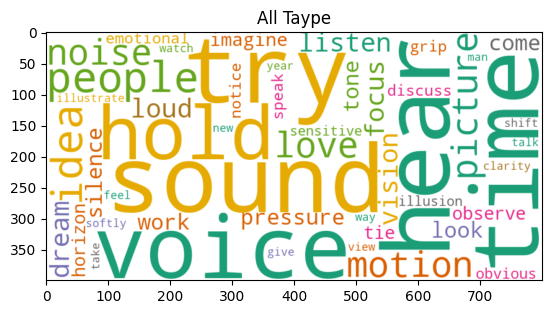

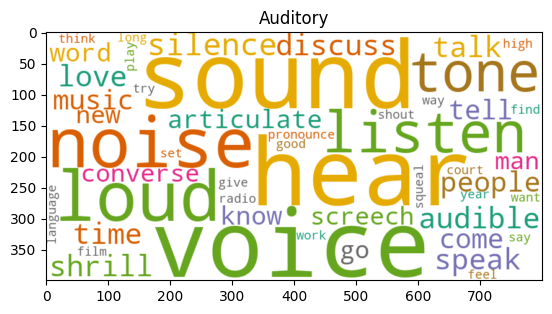

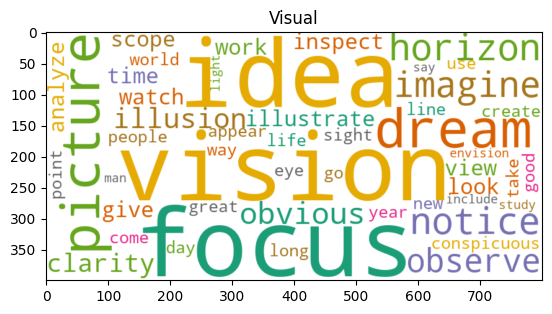

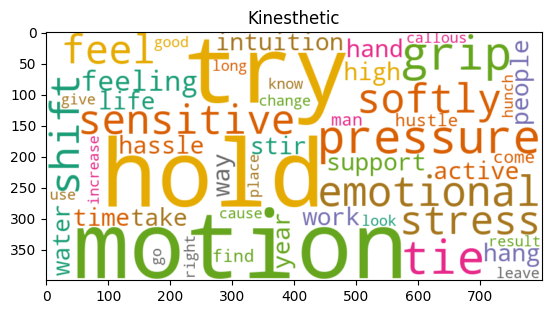

In [254]:
wordcloud = WordCloud(background_color='white',colormap='Dark2', max_font_size=150, random_state=42,width=800, height=400).generate(" ".join(all_most_frequent_world))
plt.title("All Taype")
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

wordcloud = WordCloud(background_color='white',colormap='Dark2', max_font_size=150, random_state=42,width=800, height=400).generate(" ".join(Auditory_most_frequent_world))
plt.title("Auditory")
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

wordcloud = WordCloud(background_color='white',colormap='Dark2', max_font_size=150, random_state=42,width=800, height=400).generate(" ".join(Visual_most_frequent_world))
plt.title("Visual")
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

wordcloud = WordCloud(background_color='white',colormap='Dark2', max_font_size=150, random_state=42,width=800, height=400).generate(" ".join(Kinesthetic_most_frequent_world))
plt.title("Kinesthetic")
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

# Feature And Target

In [255]:
X = df['Sentence_modified']
y = df['Type']

label_enc = LabelEncoder()
y = label_enc.fit_transform(y)
y = to_categorical(y)

In [256]:
X.shape

(14595,)

In [257]:
X[:3]

0    ali   time   love story little girl live teeny...
1    look dad   spiffe jodhpur   ready ride bay mar...
2    believe far difficult know unconscious love mo...
Name: Sentence_modified, dtype: object

In [258]:
print(label_enc.transform(label_enc.classes_))
print(list(label_enc.classes_))

[0 1 2]
['Auditory', 'Kinesthetic', 'Visual']


In [259]:
y.shape

(14595, 3)

In [260]:
y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

# Document To Vector

Data Preprocessing (Doc2Vec)

In [261]:
tqdm.pandas(desc="progress-bar")

def label_sentences(StudentSentence, label_type):
    labeled = []
    for i, v in enumerate(StudentSentence):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled 

In [262]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)

X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [263]:
all_data[0:2]

[TaggedDocument(words=['seven', 'hour', 'later', 'pacific', 'ocean', 'screenwriter', 'notice', 'fellow', 'passenger', 'begin', 'morph', 'strangely', 'voldemortian', 'way'], tags=['Train_0']),
 TaggedDocument(words=['sun', 'dip', 'horizon', 'early', 'warm', 'night', 'end', 'september', 'carnival', 'stay', 'busy', 'closing', 'o', 'clock'], tags=['Train_1'])]

In [264]:
model_dbow = Doc2Vec(dm=0, vector_size=50, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14595/14595 [00:00<00:00, 9094616.98it/s]


In [265]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors
    
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 50, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 50, 'Test')

/var/folders/7b/blc2b6zd7cn9f811xrdlsjnh0000gn/T/ipykernel_8948/976714595.py:13: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  vectors[i] = model.docvecs[prefix]


In [266]:
train_vectors_dbow.shape

(10216, 50)

In [267]:
test_vectors_dbow.shape

(4379, 50)

In [268]:
y_test.shape

(4379, 3)

In [269]:
test_vectors_dbow[:1]

array([[-0.32091501, -0.2324698 ,  0.54559904, -0.17227733,  0.0300076 ,
         0.49399555, -0.77198356,  0.31721282,  0.21507217, -0.13766995,
        -0.31330237,  0.16108948, -0.8004123 , -0.07706632, -0.14993203,
        -0.45274353, -0.24469274, -0.53878796,  0.08885436,  0.522659  ,
         0.57393253, -0.24935621, -0.21513584,  0.31994364,  0.29935467,
         0.45897788, -0.84081531,  0.71895677,  0.86671424, -0.58464986,
        -0.31522816, -0.1987776 ,  0.14490966, -0.08553335, -0.44001055,
        -0.70751482,  0.2719675 ,  0.94205976, -0.59483582, -0.06255048,
         0.04268384,  0.33405825,  0.68969381,  0.57596153,  0.17985547,
         0.05402454,  0.74882334,  0.19234921, -0.12804322,  1.31689346]])

Build And Feed The Model (Doc2Vec)

In [270]:
Early_stoping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001,
    patience=20,
    restore_best_weights=True,
)

In [271]:
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input((50, 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),  # 替换 CuDNNLSTM 为 LSTM
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])


In [272]:
model_1.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_5 (Bidirectional) │ (None, 50, 256)        │       133,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_5          │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,747 (592.76 KB)

 Trainable params: 151,747 (592.76 KB)

 Non-trainable params: 0 (0.00 B)

In [273]:
history_1 = model_1.fit(train_vectors_dbow,
          y_train,
          validation_data=(test_vectors_dbow, y_test),
          batch_size=64,
          epochs=100,
          callbacks=[Early_stoping])

Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.3847 - loss: 1.0929 - val_accuracy: 0.4092 - val_loss: 1.0829
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.3864 - loss: 1.0861 - val_accuracy: 0.4245 - val_loss: 1.0692
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.4284 - loss: 1.0670 - val_accuracy: 0.4570 - val_loss: 1.0390
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.4415 - loss: 1.0537 - val_accuracy: 0.4688 - val_loss: 1.0425
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.4549 - loss: 1.0463 - val_accuracy: 0.4812 - val_loss: 1.0192
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.4515 - loss: 1.0415 - val_accuracy: 0.4732 - val_loss: 1.0212
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.4693 - loss: 1.0294 - val_accuracy: 0.4914 - val_loss: 1.0096
Epoch 8/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.4836 - loss: 1

Model Evaluation (Doc2Vec)

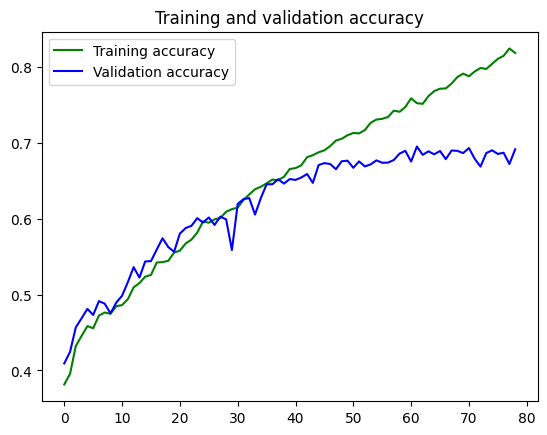

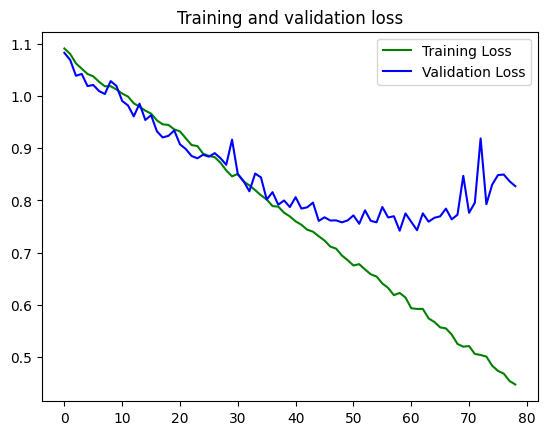

In [274]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [275]:
loss, acc=model_1.evaluate(test_vectors_dbow, y_test, verbose=1)

137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6974 - loss: 0.7302


In [276]:
print (f"Test Accuracy = {round(acc,2)} %")

Test Accuracy = 0.69 %


In [277]:
y_pred_1 = model_1.predict(test_vectors_dbow)
y_pred_1

137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


array([[0.6419821 , 0.0368701 , 0.32114777],
       [0.20001554, 0.43987337, 0.3601112 ],
       [0.8249329 , 0.046259  , 0.12880817],
       ...,
       [0.04183258, 0.2502135 , 0.7079539 ],
       [0.89025825, 0.0627955 , 0.04694625],
       [0.9287487 , 0.0039942 , 0.0672571 ]], dtype=float32)

In [278]:
y_pred_1 = np.argmax(y_pred_1, axis=1)
y_test=np.argmax(y_test, axis=1)
print(classification_report(y_test, y_pred_1, target_names=label_enc.classes_))

              precision    recall  f1-score   support

    Auditory       0.69      0.72      0.71      1399
 Kinesthetic       0.66      0.66      0.66      1358
      Visual       0.70      0.68      0.69      1622

    accuracy                           0.69      4379
   macro avg       0.68      0.69      0.69      4379
weighted avg       0.69      0.69      0.69      4379



In [281]:
#model_save_dir = '/Users/coco/Downloads/learning_chatbot/models/'
#model_save_path = os.path.join(model_save_dir, 'model_Doc2Vec')

# 保存为 TensorFlow SavedModel 格式
# 保存为 HDF5 格式
model_1.save('/Users/coco/Downloads/learning_chatbot/models/model_Doc2Vec.h5')

In [282]:
print(tf.__version__)
print(keras.__version__)

2.17.0
3.4.1


# Word Embedding

Data Preprocessing (Word Embedding)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)

In [66]:
# Tokenize words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
X_train = pad_sequences(sequences_train, maxlen=48, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=48, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary Size = {vocabSize}")

Vocabulary Size = 19308


In [67]:
X_train.shape

(10216, 48)

In [68]:
y_train.shape

(10216, 3)

In [69]:
X_test.shape

(4379, 48)

In [70]:
y_test.shape

(4379, 3)

Build And Feed The Model (Word Embedding)

In [71]:
Early_stoping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001,
    patience=20,
    restore_best_weights=True,
)

In [75]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),  # 添加 Input 层，指定输入形状
    tf.keras.layers.Embedding(vocabSize, 200),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_2.build(input_shape=(None, X_train.shape[1]))


In [76]:
model_2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 48, 200)        │     3,861,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 48, 256)        │       336,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,217,123 (16.09 MB)

 Trainable params: 4,217,123 (16.09 MB)

 Non-trainable params: 0 (0.00 B)

In [77]:
history_2 = model_2.fit(X_train,
          y_train,
          validation_data=(X_test, y_test),
          batch_size=64,
          epochs=100,
          callbacks=[Early_stoping])

Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - accuracy: 0.5163 - loss: 0.8991 - val_accuracy: 0.9507 - val_loss: 0.1474
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 25s 154ms/step - accuracy: 0.9735 - loss: 0.0998 - val_accuracy: 0.9573 - val_loss: 0.1379
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 23s 142ms/step - accuracy: 0.9878 - loss: 0.0457 - val_accuracy: 0.9543 - val_loss: 0.1694
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - accuracy: 0.9909 - loss: 0.0320 - val_accuracy: 0.9523 - val_loss: 0.1793
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 23s 142ms/step - accuracy: 0.9937 - loss: 0.0218 - val_accuracy: 0.9500 - val_loss: 0.1928
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.9932 - loss: 0.0219 - val_accuracy: 0.9482 - val_loss: 0.1960
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.9943 - loss: 0.0195 - val_accuracy: 0.9475 - val_loss: 0.2114
Epoch 8/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.9955 -

Model Evaluation (Word Embedding)

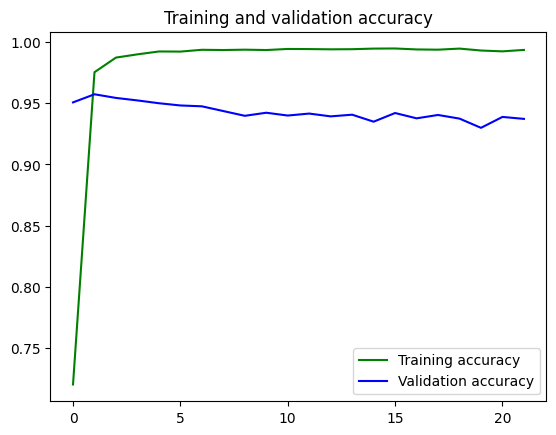

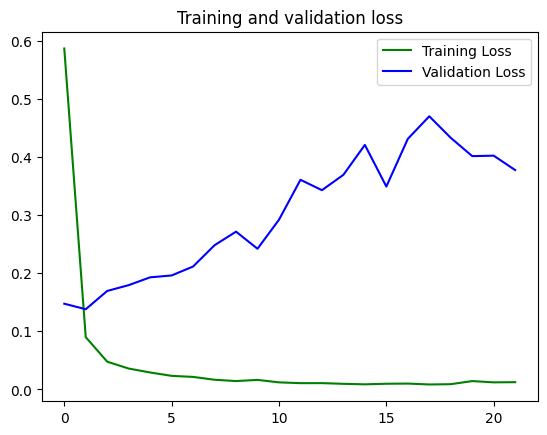

In [78]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [79]:
y_test

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [80]:
loss, acc=model_2.evaluate(X_test, y_test, verbose=1)

137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9553 - loss: 0.1378


In [81]:
print (f"Test Accuracy = {round(acc,2)} %")

Test Accuracy = 0.96 %


In [82]:
y_pred_2 = model_2.predict(X_test)
y_pred_2

137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step


array([[9.9495304e-01, 2.0054365e-03, 3.0415566e-03],
       [5.8646791e-04, 7.2369445e-03, 9.9217653e-01],
       [9.9188739e-01, 2.3360660e-03, 5.7765087e-03],
       ...,
       [4.6114268e-04, 9.9854445e-01, 9.9447451e-04],
       [9.9939406e-01, 5.1544477e-05, 5.5433612e-04],
       [9.9986827e-01, 8.9880668e-06, 1.2281605e-04]], dtype=float32)

In [83]:
y_pred_2 = np.argmax(y_pred_2, axis=1)
y_test=np.argmax(y_test, axis=1)
print(classification_report(y_test, y_pred_2, target_names=label_enc.classes_))

              precision    recall  f1-score   support

    Auditory       0.94      0.96      0.95      1399
 Kinesthetic       0.97      0.96      0.97      1358
      Visual       0.96      0.95      0.96      1622

    accuracy                           0.96      4379
   macro avg       0.96      0.96      0.96      4379
weighted avg       0.96      0.96      0.96      4379



In [84]:
#model_2.save('model_WordEmbedding.h5')
model_save_path = os.path.join(model_save_dir, 'model_WordEmbedding.keras')
model_2.save(model_save_path)

In [163]:
import spacy
import numpy as np

# 加载SpaCy模型
nlp = spacy.load('en_core_web_sm')

model = model_1  # 你之前训练的模型
tokenizer = Tokenizer()

# 假设label_enc是之前训练中使用的LabelEncoder实例
label_enc = LabelEncoder()
label_enc.classes_ = np.array(['Auditory', 'Kinesthetic', 'Visual'])  # 你的类别名称，确保顺序与训练时相同

# 输入句子
input_sentence = "I learn best when i draw a picture."

# 使用之前定义的预处理函数
def clean_text(text):
    text = re.sub(r"https?://\S+|www\.\S+", "", text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    text = ' '.join(text.split())  # Remove extra spaces
    return text

# 应用SpaCy的词形还原和停用词过滤
cleaned_sentence = ' '.join([token.lemma_ for token in nlp(clean_text(input_sentence)) if not token.is_stop])

# 将句子转换为模型可接受的格式
sequence = tokenizer.texts_to_sequences([cleaned_sentence])
padded_sequence = pad_sequences(sequence, maxlen=200)  # 假设模型输入的最大长度是200


# 进行预测
pred = model.predict(padded_sequence)

# 输出预测概率
for idx, style in enumerate(label_enc.classes_):
    print(f"Probability of '{style}': {pred[0][idx]:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Probability of 'Auditory': 0.60%
Probability of 'Kinesthetic': 0.04%
Probability of 'Visual': 0.36%


['类别1' '类别2' '类别3']
